![img](https://images.unsplash.com/photo-1616617774879-179911b66e75?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1279&q=80)

# Проект 6. Выбираем авто выгодно

## Постановка задачи

Собрать данные для тренировочного набора с помощью web-scraping, проанализировать и обработать эти данные, а в дальнейшем попробовать обучить на данных различные модели машинного обучения. По результатам с помощью метрики MAPE(Mean Percentage Absolute Error) выбрать модель, которая будет более точно предсказывать стоимость автомобиля по его характеристикам

## Изучение предметной области

При изучение аналитических статей по ценообразованию на вторичном рынке автомобилей отмечены следующие признаки, влияющие на стоимость:
* марка авто
* трансмиссия (для городской местности автомат на 30-60 тыс руб дороже)
* привод (полный на 30-50 тыс руб дороже)
* цвет авто (черные, белый, серебристый - дороже; оранжевыйб синийб зеленый, красный - дешевле)
* электроника
* дополнительные технологии
* внешний вид
* состояние салона
* техническое состояние
* пробег
* оригинальность ПТС

Часть этих признаков(марка, трансмиссия, привод, пробег, ПТС) представлены в обучающей и тестовой выборках и их влияние на цену можно проверить при построении модели. Однако такие признаки как состояние салона, внешний вид, техническое состояние пока не представляется возможным проверить при построении модели, не известно как обработать изображения машин и оценить состояние.

Что еще влияет на стоимость автомобилей и какие имеются зависимости?

* цены на подержание авто находятся в прямой зависимости от стоимости новой модели,
* чем дороже авто , тем быстрее он падает в цене за первые 3 года эксплуатации,
* в малом среднем классе ощущается меньше разрыв между ценами на подержаные авто и новые,
* сезонные факторы, например, при больших скидках на новые машины в конце года, также падают цены на вторичном рынке,
* по прогнозам к концу 2020 года машины должны были подорожать на 5-20% из- за падения курса рубля, на вторичном рынке временной лаг 1-2 месяца и за 6-10 месяцев цены на вторичном рынке догоняют первичный

Эти эвристики находятся за пределами нашего проекта, так как мы не располагаем данными на новые автомобили

Один из факторов, влияюших на цену подержаных автомобилей, это принимаемое законодательство. Например, с 1 мая 2021 продавать подержаные автомобили можно через сайт госуслуг. Предполагается, что это может вызвать снижение стоимости на 3-5%. Также Российское Правительство утвержило документы согласно которым к конце первого квартала 2021 года утилизационный сбор на легковые автомобили увеличен на 25% , а на спецтехнику в 3 и более раза. Это приведет к рсту цен на импортные автомобили, так как утиль сбор закладывается в финальную цену. Подобное повышение было в начале прошлого года, когда повыщающие коэффициенты были привязаны к объему двигателя и вызвали рост цен в марте-апреле 2020 на новые авто на 5-7%. Эти факторы, которые отразятся на ценах авто в будущем, мы не можем учесть при обучении модели, но они могли бы быть учтены при дообучении модели. 

## Загрузка / установка необходимых библиотек

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_regression, mutual_info_regression 
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

import warnings 
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500) 
sns.set(rc={'figure.figsize': (8, 5)}) 
plt.style.use('seaborn-deep')


## Загрузка и первичный просмотр данных

 **Описания полей**
 - **bodyType** - тип кузова
 - **brand** - марка автомобиля 
 - **car_url** - ссылка на автомобиль
 - **color** - цвет автомобиля
 - **complectation_dict**  - комплектация (словарь)
 - **description** - описание
 - **engineDisplacement** - объем двигателя
 - **enginePower** - мощность двигателя
 - **equipment_dict** - комплектация(словарь)
 - **fuelType** - тип топлива (значения: бензин,дизель, электро, гибрид, газ)
 - **image** - фотография/изображение
 - **mileage** - пробег (километры)
 - **modelDate** - дата модели
 - **model_info** - информация о модели
 - **model_name** - название модели
 - **name** - наименование двигатель и тип трансмиссии
 - **numberOfDoors** - количество дверей
 - **parsing_unixtime** - дата время парсинга
 - **priceCurrency** - валюта для цены
 - **productionDate** - дата производства
 - **sell_id** - идентификатор продажи
 - **super_gen** -  дополнительная информация          
 - **vehicleConfiguration** - конфигурация автомобиля
 - **vehicleTransmission** - трансмиссия / коробка передач (значения:механическая, автоматическая, вариатор, роботизированная)
 - **vendor** - производитель              
 - **Владельцы** - количество предыдущих владельцев (значения: 1, 2, 3 и более)
 - **Владение** - владение            
 - **ПТС** - наличие/ отсутствие ПТС
 - **Привод** - тип привода (значения: передний, задний,полный)              
 - **Руль** - расположение руля (значения: левый / правый)
 - **Состояние** - состояние автомобиля (значения: требует / не требует ремонта)
 - **Таможня** - ратоможен/нерастоможен

In [167]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [168]:
print('train:', train.shape)
print('test:', test.shape)

train: (45145, 33)
test: (34686, 32)


In [169]:
print('train:')
display(train.head(3))
print()
print('test:')
display(test.head(3))

train:


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
0,хэтчбек 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/a3/1072164...,чёрный,NaN,Машину покупали в Ауди Центр-Таганка в 2012-м ...,1.2 LTR,105 N12,"{'engine-proof': True, 'cruise-control': True,...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,117000.0,2008.0,"{'code': 'A3', 'name': 'A3', 'ru_name': 'А3'}",A3,1.2 AMT (105 л.с.),5.0,1618655932,RUB,2012.0,1.072165e+09,"{'id': '6451920', 'name': '', 'nameplate': '',...",HATCHBACK_5_DOORS ROBOT 1.2,роботизированная,NaN,1 владелец,8 лет и 9 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,680000.0
1,седан,AUDI,https://auto.ru/cars/used/sale/audi/a6/1102843...,красный,NaN,Машина в отличном состоянии!\nПокраски не треб...,2.4 LTR,177 N12,"{'engine-proof': True, 'tinted-glass': True, '...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,214000.0,2004.0,"{'code': 'A6', 'name': 'A6', 'ru_name': 'А6'}",A6,2.4 CVT (177 л.с.),4.0,1618655934,RUB,2005.0,1.102843e+09,"{'id': '6297759', 'name': '', 'nameplate': '',...",SEDAN VARIATOR 2.4,вариатор,NaN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,535000.0
2,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/polo...,белый,NaN,В РОЛЬФ Юг | Автомобили с пробегом только самы...,1.6 LTR,110 N12,"{'electro-window-back': True, 'asr': True, 'pt...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,96250.0,2014.0,"{'code': 'POLO', 'name': 'Polo', 'ru_name': 'П...",POLO,1.6 MT (110 л.с.),4.0,1618655935,RUB,2016.0,1.102807e+09,"{'id': '20726508', 'name': '', 'nameplate': ''...",SEDAN MECHANICAL 1.6,механическая,NaN,2 владельца,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,598000.0



test:


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [170]:
train = train.drop_duplicates()
train.duplicated().sum()

0

In [171]:
train.shape

(45145, 33)

## Целевая переменная и удаление ненужных признаков

In [172]:
col_drop = ['car_url', 'complectation_dict', 'image', 'model_info',
            'name', 'parsing_unixtime', 'priceCurrency', 'sell_id', 'vehicleConfiguration']
#  'description',

In [173]:
train.drop(col_drop, axis=1, inplace=True)
test.drop(col_drop, axis=1, inplace=True)

Посмотрим на распределение целевой переменной

In [174]:
train.dropna(subset=['price'], inplace=True)

Логорифмируем таргет

In [175]:
train.price = np.log(train.price)

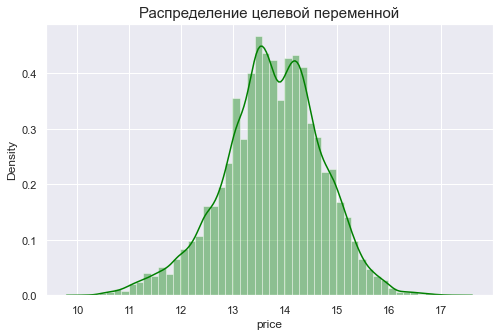

In [176]:
plt.title('Распределение целевой переменной', fontsize=15)
sns.distplot(train.price, color='green');

## Работа с пропусками

In [177]:
print('train:')
display(train.isna().sum()[train.isna().sum() > 0])
print()
print('test:')
display(test.isna().sum()[test.isna().sum() > 0])

train:


bodyType                   1
fuelType                   1
modelDate                  1
numberOfDoors              1
super_gen                  1
vehicleTransmission        1
vendor                 44599
Владельцы                  1
Владение               31098
ПТС                        3
Привод                     1
dtype: int64


test:


equipment_dict     9996
Владение          22691
ПТС                   1
dtype: int64

In [178]:
train.dropna(subset=['ПТС', 'bodyType', 'Владельцы'], inplace=True)

In [179]:
european = ['SKODA', 'AUDI', 'VOLVO', 'BMW', 'MERCEDES', 'VOLKSWAGEN']
japanese = ['HONDA', 'NISSAN', 'INFINITI', 'TOYOTA', 'LEXUS', 'MITSUBISHI']

train.loc[train.brand.isin(european), 'vendor'] = 'EUROPEAN'
train.loc[train.brand.isin(japanese), 'vendor'] = 'JAPANESE'

In [180]:
test['ПТС'].fillna(train.ПТС.mode()[0], inplace=True)
train.equipment_dict.fillna('{}', inplace=True)
test.equipment_dict.fillna('{}', inplace=True)

In [181]:
print('train:')
display(train.isna().sum()[train.isna().sum() > 0])
print()
print('test:')
display(test.isna().sum()[test.isna().sum() > 0])

train:


Владение    31093
dtype: int64


test:


Владение    22691
dtype: int64

Сгруппируем признаки в  категории по типу их обработки (категориальные, числовые, признаки состоящие из словарей) для дальнейшего удобного анализа. 

In [182]:
num_cols = ['mileage', 'modelDate', 'numberOfDoors', 'productionDate']
cat_cols = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
            'fuelType', 'model_name', 'vehicleConfiguration', 'vehicleTransmission', 
            'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня']
dict_col = ['equipment_dict', 'super_gen']

In [183]:
train.reset_index(drop=True, inplace=True)

In [184]:
train[num_cols] = train[num_cols].astype('int64')
test[num_cols] = test[num_cols].astype('int64')

In [185]:
def cat_plot(col, rotation=90):
    df = train[col].value_counts()
    plt.title(f'Распределение {col}', fontsize=15)
    sns.barplot(x=df.index, y=df.values, palette='Blues_r_d')
    plt.xticks(rotation=rotation);  

In [186]:
def cat_boxplot(col, rotation=90):
    plt.title(f'Распределение цен на авто от значений {col}', fontsize=15)
    sns.boxplot(x=col, y='price', data=train, palette='Blues_r_d')
    plt.xticks(rotation=rotation);  

## Числовые

Преобразуем modelDate и productionDate

In [187]:
train['model_year'] = 2021 - train['modelDate']
test['model_year'] = 2021 - test['modelDate']

train['production_year'] = 2021 - train['productionDate']
test['production_year'] = 2021 - test['productionDate']

train.drop(['modelDate', 'productionDate'], axis=1, inplace=True)
test.drop(['modelDate', 'productionDate'], axis=1, inplace=True)

In [188]:
num_cols.remove('modelDate')
num_cols.remove('productionDate')
num_cols = num_cols + ['model_year', 'production_year']

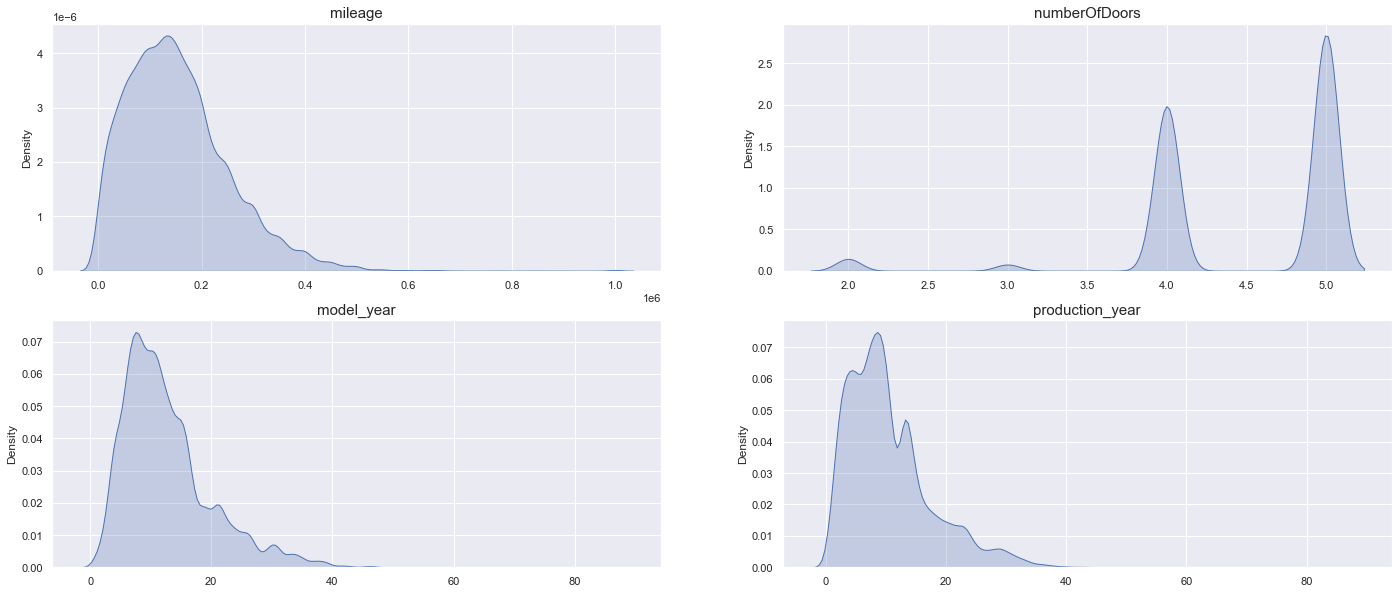

In [189]:
plt.figure(figsize=(24,10))
for i, col in enumerate(num_cols):
    plt.subplot(2,2, i+1)
    plt.title(col, fontsize=15)
    sns.kdeplot(x=col, data=train, shade=True)
    plt.xlabel(None)  

На основе этих графиков можно сделать вывод, что пробег состявляет у большинства машин 160000 км. Основные категории состявляют 4-5 дверные машины, имеется небольшой процент 2-х и 3-х дверных машин. Графики для modelDate и productionDate в целом очень похожи. Представленные машины были произведены в период с 1980 по 2020 годы (также имеются и более ранние машины, но их очень мало). Основную массу составляют машины примерно, начиная с 2010 года.

Создадим признак средний пробег в год

In [190]:
train['mileage_year'] = train.mileage * (train.production_year + 1)
test['mileage_year'] = test.mileage * (test.production_year + 1)

train['mileage_year'] = np.log(train['mileage_year'])
test['mileage_year'] = np.log(test['mileage_year'])

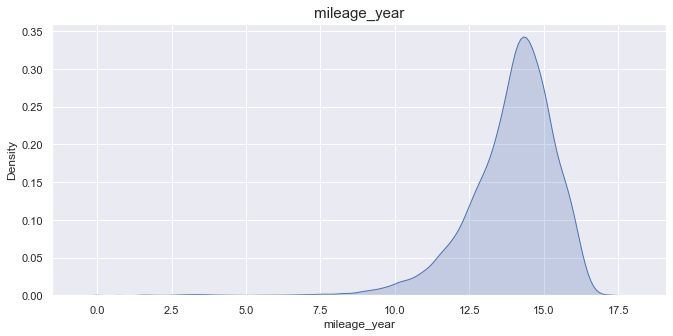

In [191]:
plt.figure(figsize=(11,5))
plt.title('mileage_year', fontsize=15)
sns.kdeplot(x='mileage_year', data=train, shade=True);

In [192]:
num_cols.append('mileage_year')

## Категориальные

In [193]:
def check_values_train(col):
    train_col = set(train[col].unique())
    test_col = set(test[col].unique())
    result = test_col - train_col
    if len(result) == 0:
        print('Все уникальные значения test присутствуют в train')
    else:
        print(f'В train.{col} нет значений: {result}')
        
def check_values_test(col):
    train_col = set(train[col].unique())
    test_col = set(test[col].unique())
    result = train_col - test_col
    if len(result) == 0:
        print('Все уникальные значения train присутствуют в test')
    else:
        print(f'В test.{col} нет значений: {result}')

### bodyType

In [194]:
train.bodyType = train.bodyType.str.findall(r'^\S+').str[0]
test.bodyType = test.bodyType.str.findall(r'^\S+').str[0]

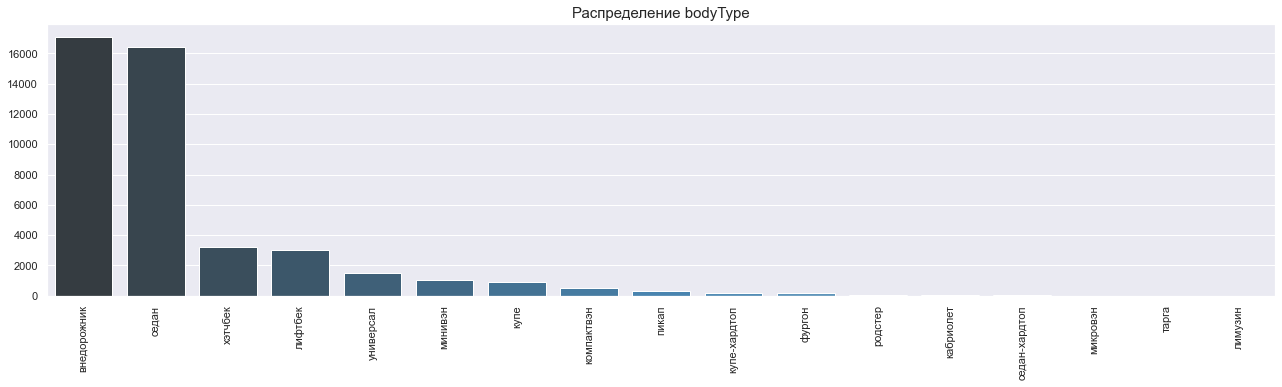

In [195]:
plt.figure(figsize=(22,5))
cat_plot('bodyType')

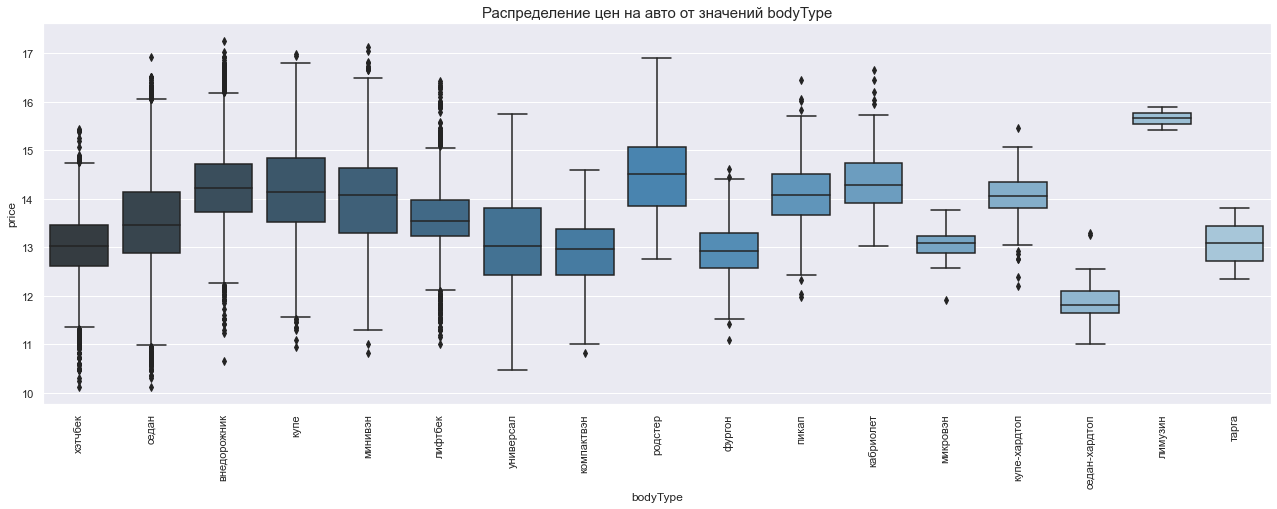

In [196]:
plt.figure(figsize=(22,7))
cat_boxplot('bodyType')

In [197]:
check_values_train('bodyType')
check_values_test('bodyType')

В train.bodyType нет значений: {'фастбек'}
Все уникальные значения train присутствуют в test


In [198]:
test.loc[test.bodyType == 'фастбек', 'bodyType'] = 'хэтчбек'

Создадис признак частота кузова

In [199]:
fq = train.bodyType.value_counts(normalize=True).to_dict()

train['bodyType_fq'] = train.bodyType.map(fq)
test['bodyType_fq'] = test.bodyType.map(fq)


### brand

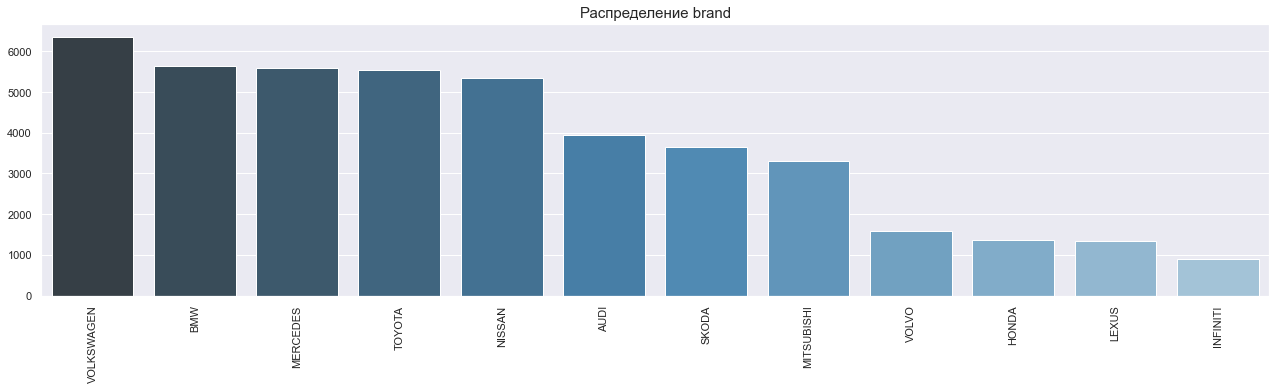

In [200]:
plt.figure(figsize=(22,5))
cat_plot('brand')

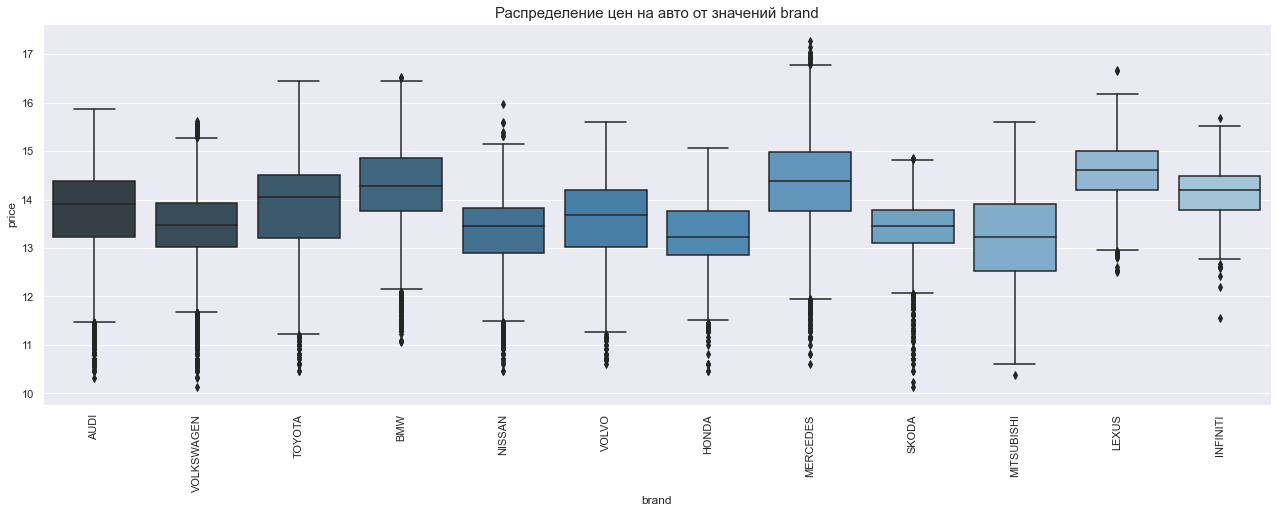

In [201]:
plt.figure(figsize=(22,7))
cat_boxplot('brand')

- топ дорогих брендов: BMW, Mercedes, Lexus, Ifiniti

In [202]:
check_values_train('brand')
check_values_test('brand')

Все уникальные значения test присутствуют в train
Все уникальные значения train присутствуют в test


Создадим признаки средняя цена по брендам и длина бренда

In [203]:
dict_price = train.groupby('brand').price.mean().to_dict()

train['brand_price'] = train.brand.map(dict_price)
test['brand_price'] = test.brand.map(dict_price)

train['brand_len'] = train.brand.apply(len)
test['brand_len'] = test.brand.apply(len)

In [204]:
num_cols.append('brand_price')
num_cols.append('brand_len')

### color

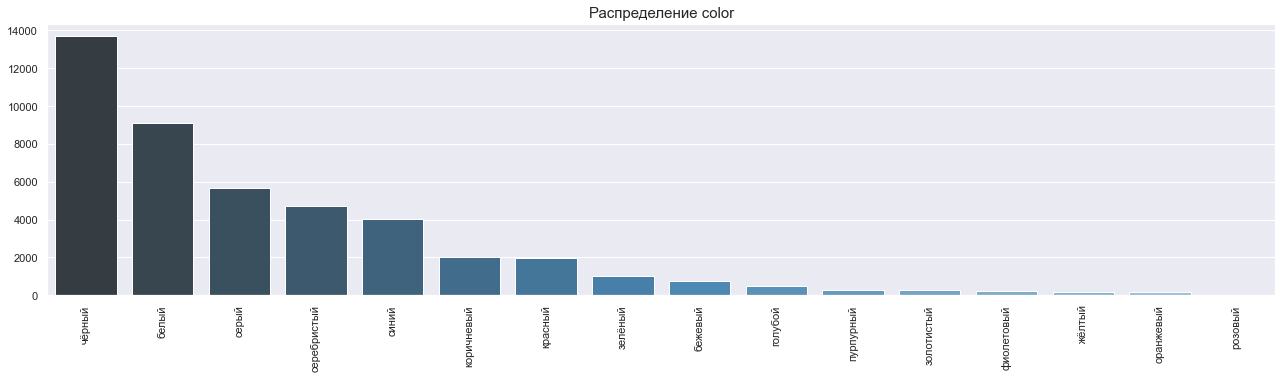

In [205]:
plt.figure(figsize=(22,5))
cat_plot('color')

- топ цвета: черный, белый
- непопулярные цвета: розовый, оранжевый, желтый

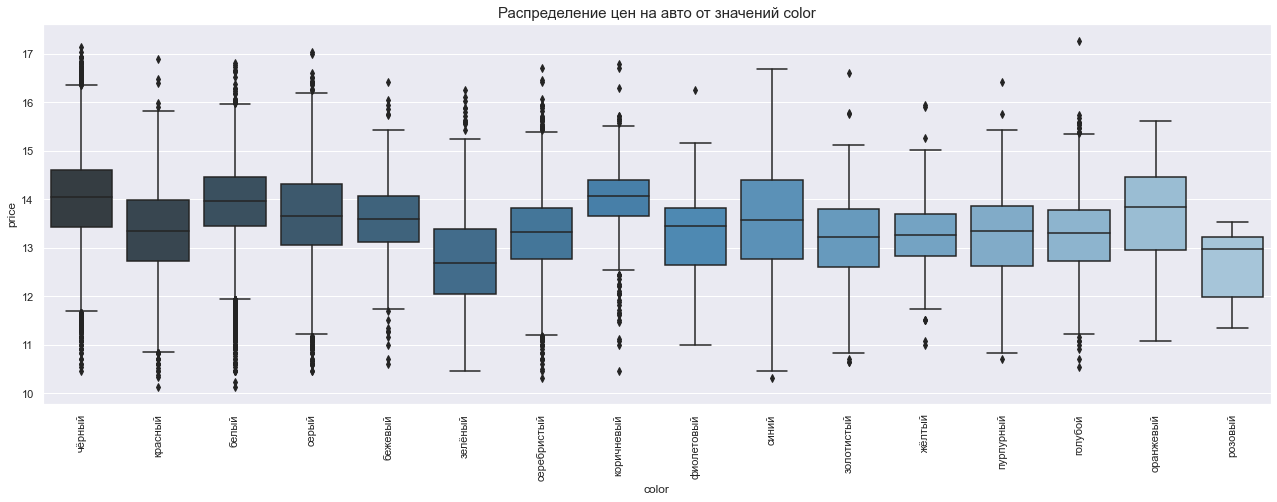

In [206]:
plt.figure(figsize=(22,7))
cat_boxplot('color')

- у розоовых и зеленых авто самые низкие цены

In [207]:
check_values_train('color')
check_values_test('color')

Все уникальные значения test присутствуют в train
Все уникальные значения train присутствуют в test


Создадим признак частота цвета

In [208]:
fq = train.color.value_counts(normalize=True).to_dict()

train['color_fq'] = train.color.map(fq)
test['color_fq'] = test.color.map(fq)

### description

Токенизация описания не улучшила результат.

In [209]:
#Create lemmatizer and stopwords list
# mystem = Mystem() 
# rus_stopwords = stopwords.words("russian")

In [210]:
#Preprocess function
# def preprocess_text(text):
#     tokens = mystem.lemmatize(text.lower())
#     tokens = [token for token in tokens if token not in rus_stopwords\
#               and token != " " \
#               and token.strip() not in punctuation]
#     text = " ".join(tokens)
#     return text

In [211]:
# vectorizer = CountVectorizer(stop_words=rus_stopwords).build_analyzer()

# train.description = train.description.apply(vectorizer).apply(lambda x: ' '.join(x))
# test.description = test.description.apply(vectorizer).apply(lambda x: ' '.join(x))

# train.description = train.description.apply(preprocess_text)
# test.description = test.description.apply(preprocess_text)

In [212]:
# vectorizer = CountVectorizer(stop_words=rus_stopwords).build_analyzer()
# tfid_vectorizer = TfidfVectorizer(stop_words=rus_stopwords, max_features=50) 

In [213]:
# train['description_len'] = train.description.apply(vectorizer).apply(len)
# test['description_len'] = test.description.apply(vectorizer).apply(len)

# num_cols.append('description_len')

In [214]:
# train_words = tfid_vectorizer.fit_transform(train.description).toarray()
# test_words = tfid_vectorizer.transform(test.description).toarray()

In [215]:
# train_words = pd.DataFrame(train_words, columns=tfid_vectorizer.get_feature_names())
# test_words = pd.DataFrame(test_words, columns=tfid_vectorizer.get_feature_names())

In [216]:
# train = pd.concat([train, train_words], axis=1)
# test = pd.concat([test, test_words], axis=1)

In [217]:
train.drop('description', axis=1, inplace=True)
test.drop('description', axis=1, inplace=True)

### engineDisplacement

In [218]:
train.engineDisplacement = train.engineDisplacement.str.findall(r"\d.\d").str[0]
train.engineDisplacement.fillna('0', inplace=True)

test.engineDisplacement = test.engineDisplacement.str.findall(r"\d.\d").str[0]
test.engineDisplacement.fillna('0', inplace=True)


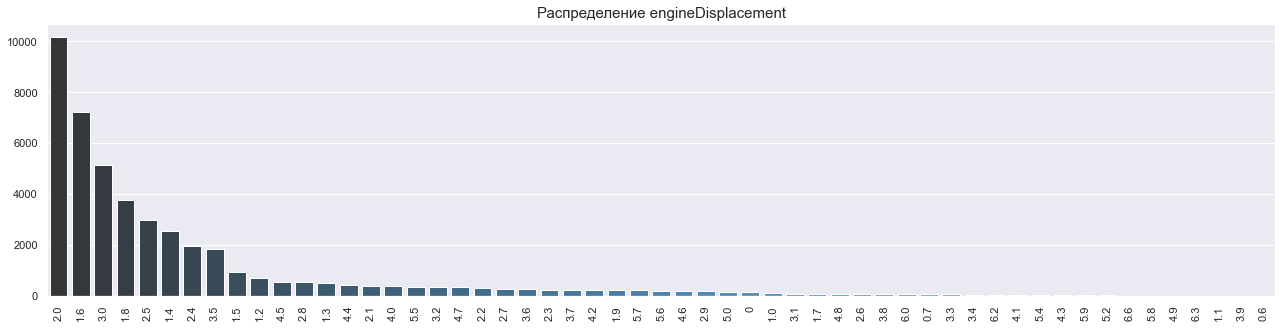

In [219]:
plt.figure(figsize=(22,5))
cat_plot('engineDisplacement', rotation=90)

- топ объемов двигателя: 2.0, 1.6, 3.0

In [220]:
check_values_train('engineDisplacement')
check_values_test('engineDisplacement')

В train.engineDisplacement нет значений: {'5.3'}
В test.engineDisplacement нет значений: {'0.6'}


In [221]:
train['engineDisplacement'] = train.engineDisplacement.astype('float64')
test['engineDisplacement'] = test.engineDisplacement.astype('float64')

### enginePower

In [222]:
train.enginePower = train.enginePower.str.findall(r'^\S+').str[0]
test.enginePower = test.enginePower.str.findall(r'^\S+').str[0]

train.enginePower = train.enginePower.apply(lambda x: int(x))
test.enginePower = test.enginePower.apply(lambda x: int(x))

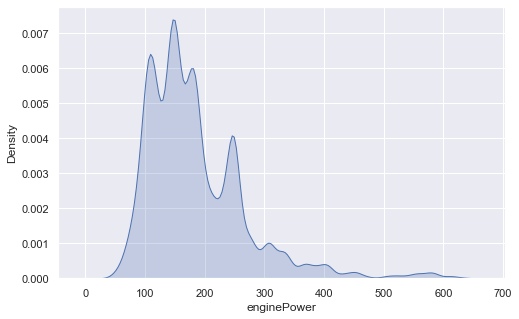

In [223]:
sns.kdeplot(x='enginePower', data=train, shade=True);

- средняя мощность двигателя: 150 л.с.

Создадим признак, налог на авто

In [224]:
def enginePower_rate(power):
    if power > 250:
        return 150
    elif power > 225:
        return 75
    elif power > 200:
        return 65
    elif power > 175:
        return 50
    elif power > 150:
        return 45
    elif power > 125:
        return 35
    elif power > 100:
        return 25
    else:
        return 12

In [225]:
train['enginePower_rate'] = train.enginePower.apply(enginePower_rate)
test['enginePower_rate'] = test.enginePower.apply(enginePower_rate)

train['tax'] = train.enginePower_rate * train.enginePower
test['tax'] = test.enginePower_rate * test.enginePower

In [226]:
# train.drop('enginePower_rate', axis=1, inplace=True)
# test.drop('enginePower_rate', axis=1, inplace=True)
num_cols.append('tax')
num_cols.append('engineDisplacement')
num_cols.append('enginePower')

### fuelType

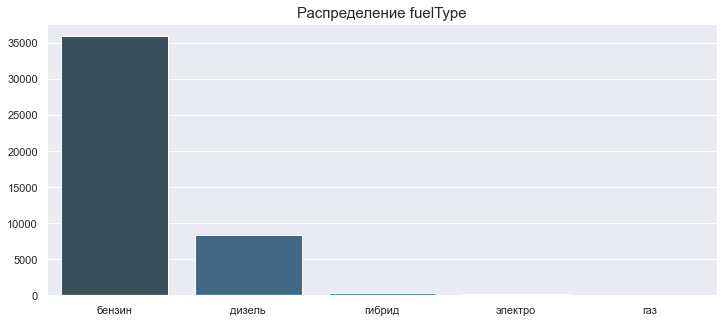

In [227]:
plt.figure(figsize=(12,5))
cat_plot('fuelType', rotation=0)

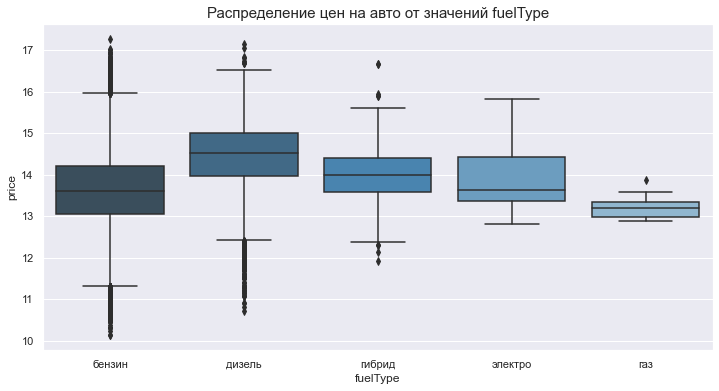

In [228]:
plt.figure(figsize=(12,6))
cat_boxplot('fuelType', rotation=0)

In [229]:
check_values_train('fuelType')
check_values_test('fuelType')

Все уникальные значения test присутствуют в train
Все уникальные значения train присутствуют в test


### model_name

In [230]:
check_values_train('model_name')
check_values_test('model_name')

В train.model_name нет значений: {'A2', 'VIGOR', 'KIX', 'ELYSION', 'GOLF_R32', 'POPULAR', 'CALIFORNIA', 'SPRINTER_CARIB', 'VANGUARD', 'SCEPTER_SEDAN', 'GRANVIA', 'EMERAUDE', 'ORIGIN', 'TARO', '140', 'SIGMA', 'SLC_KLASSE', 'ASPIRE', '100_SERIES', 'EUROVAN', 'E3', 'DAYZ_ROOX', 'RAFAGA', 'TERRANO_REGULUS', 'PROGRES', 'TT_RS', 'ATLAS', 'NADIA', 'DELICA_D2', 'SIMPLEX', '100NX', 'M1', '280ZX', 'V60', 'PASEO', 'ZEST', 'VEZEL', 'COUPE', 'CITY', 'VERSO_S'}
В test.model_name нет значений: {'ROOMY', 'LC', 'EXA', 'S_MX', 'CLK_KLASSE_AMG', 'ROGUE', 'PASSAT_NA', 'METRIS', 'GOLF_COUNTRY', 'LANCER_CARGO', 'SAI', '3000_GT', 'JADE', 'IS_F', 'BREVIS', 'TACOMA', 'PAJERO_JUNIOR', 'ETERNA', 'LATIO', 'VAMOS', 'LIBERTA_VILLA', 'FIT_SHUTTLE', '1200', 'PRIMASTAR', 'SQ7', '600', 'SLK_KLASSE_AMG', 'MDX', 'LIFE', 'CIMA', 'W108', 'PASSPORT', 'LANGLEY', 'VOLTZ', 'GTO', '220_W187', 'TOURING_HIACE', 'EQC', 'W29', 'Q3_SPORTBACK', 'CAPA', 'TYPE_2', 'PRONARD', 'PIXIS_VAN', 'W115', 'BEAT', 'DELICA_D3', '2000_C_CS'}


In [231]:
def check_values_train_del(col):
    train_col = set(train[col].unique())
    test_col = set(test[col].unique())
    result = train_col - test_col
    return result

model_del = check_values_train_del('model_name')
train = train.loc[~train.model_name.isin(model_del), :] 

In [232]:
check_values_train('model_name')
check_values_test('model_name')

В train.model_name нет значений: {'A2', 'VIGOR', 'KIX', 'ELYSION', 'GOLF_R32', 'POPULAR', 'CALIFORNIA', 'SPRINTER_CARIB', 'VANGUARD', 'SCEPTER_SEDAN', 'GRANVIA', 'EMERAUDE', 'ORIGIN', 'TARO', '140', 'SIGMA', 'SLC_KLASSE', 'ASPIRE', '100_SERIES', 'EUROVAN', 'E3', 'DAYZ_ROOX', 'RAFAGA', 'TERRANO_REGULUS', 'PROGRES', 'TT_RS', 'ATLAS', 'NADIA', 'DELICA_D2', 'SIMPLEX', '100NX', 'M1', '280ZX', 'V60', 'PASEO', 'ZEST', 'VEZEL', 'COUPE', 'CITY', 'VERSO_S'}
Все уникальные значения train присутствуют в test


Создадим признак хэш модели

In [233]:
train['model_name_hash'] = train.model_name.apply(lambda x: abs(hash(x)))
test['model_name_hash'] = test.model_name.apply(lambda x: abs(hash(x)))

In [234]:
scaler = StandardScaler()
train['model_name_hash'] = scaler.fit_transform(train[['model_name_hash']])
test['model_name_hash'] = scaler.transform(test[['model_name_hash']])

In [235]:
train.drop('model_name', axis=1, inplace=True)
test.drop('model_name', axis=1, inplace=True)

### vehicleTransmission

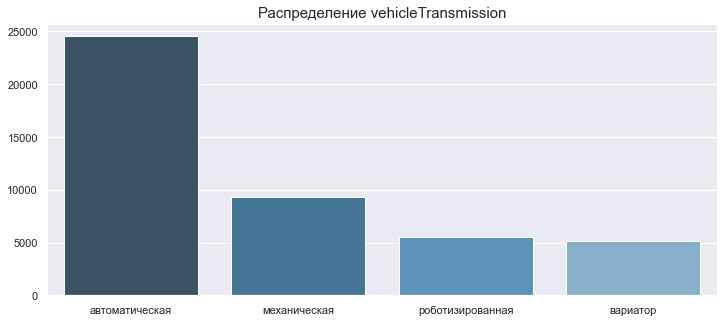

In [236]:
plt.figure(figsize=(12,5))
cat_plot('vehicleTransmission', rotation=0)

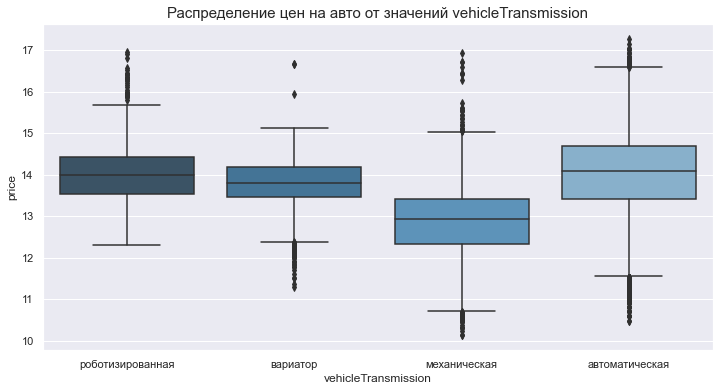

In [237]:
plt.figure(figsize=(12,6))
cat_boxplot('vehicleTransmission', rotation=0)

In [238]:
check_values_train('vehicleTransmission')
check_values_test('vehicleTransmission')

Все уникальные значения test присутствуют в train
Все уникальные значения train присутствуют в test


### vendor

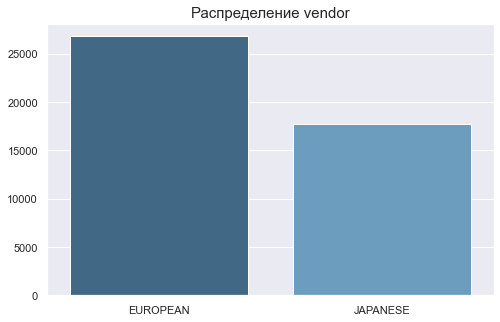

In [239]:
cat_plot('vendor', rotation=0)

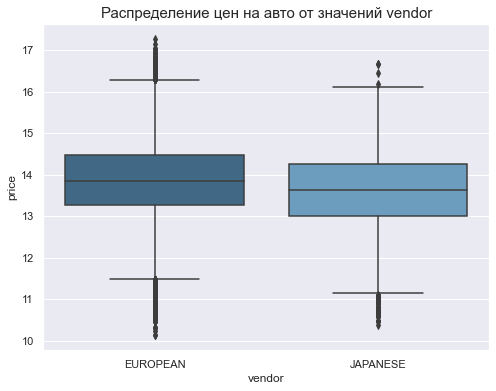

In [240]:
plt.figure(figsize=(8,6))
cat_boxplot('vendor', rotation=0)

In [241]:
check_values_train('vendor')
check_values_test('vendor')

Все уникальные значения test присутствуют в train
Все уникальные значения train присутствуют в test


In [242]:
vendor_dict = {'EUROPEAN': 0, 'JAPANESE': 1}

train.vendor = train.vendor.map(vendor_dict)
test.vendor = test.vendor.map(vendor_dict)

### Владельцы

In [243]:
train.Владельцы = train.Владельцы.str.findall('\d').str[0]
test.Владельцы = test.Владельцы.str.findall('\d').str[0]

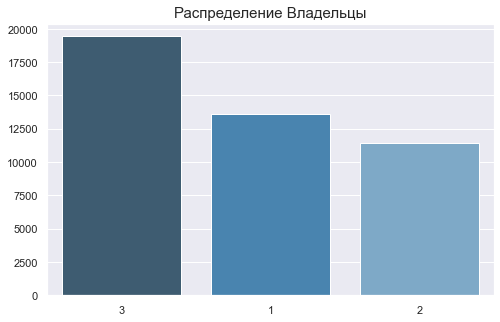

In [244]:
cat_plot('Владельцы', rotation=0)

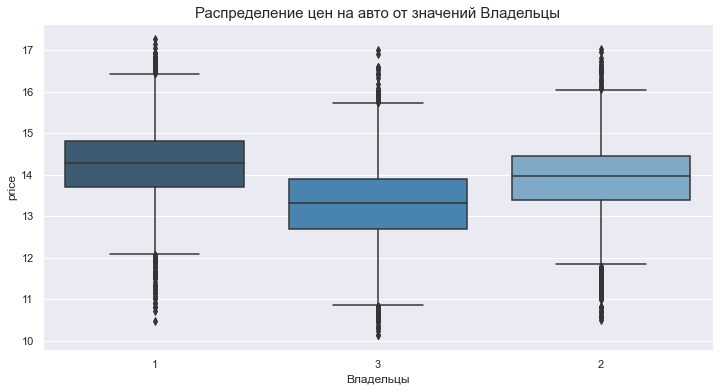

In [245]:
plt.figure(figsize=(12,6))
cat_boxplot('Владельцы', rotation=0)

- с увеличение владельцев авто падает цена

In [246]:
check_values_train('Владельцы')
check_values_test('Владельцы')

Все уникальные значения test присутствуют в train
Все уникальные значения train присутствуют в test


In [247]:
train.Владельцы = train.Владельцы.astype('int32')
test.Владельцы = test.Владельцы.astype('int32')

### Владение

In [248]:
train.Владение_isna = train.Владение.fillna(0).astype('bool') * 1
test.Владение_isna = test.Владение.fillna(0).astype('bool') * 1

In [249]:
train.drop('Владение', axis=1, inplace=True)
test.drop('Владение', axis=1, inplace=True)

### ПТС

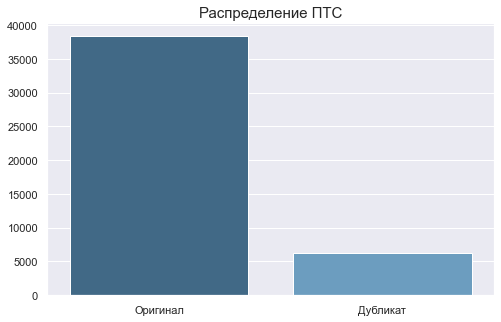

In [250]:
cat_plot('ПТС', rotation=0)

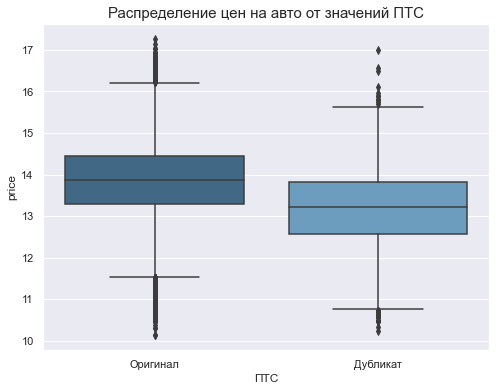

In [251]:
plt.figure(figsize=(8,6))
cat_boxplot('ПТС', rotation=0)

- цены на авто с дубликатом ПТС ниже чем с оригинал

In [252]:
check_values_train('ПТС')
check_values_test('ПТС')

Все уникальные значения test присутствуют в train
Все уникальные значения train присутствуют в test


In [253]:
pts_dict = {'Оригинал': 0, 'Дубликат': 1}

train.ПТС = train.ПТС.map(pts_dict)
test.ПТС = test.ПТС.map(pts_dict)

### Привод

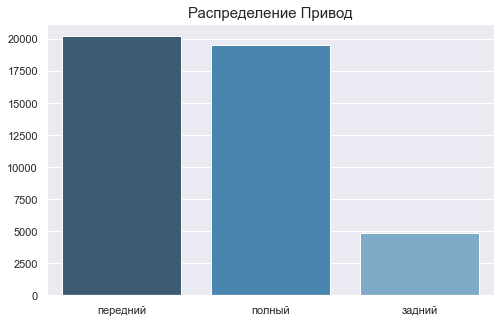

In [254]:
cat_plot('Привод', rotation=0)

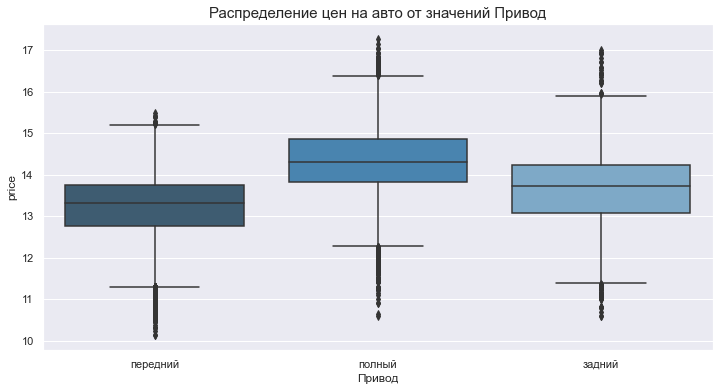

In [255]:
plt.figure(figsize=(12,6))
cat_boxplot('Привод', rotation=0)

- авто с полным приводом в среднем дороже остальных

In [256]:
check_values_train('Привод')
check_values_test('Привод')

Все уникальные значения test присутствуют в train
Все уникальные значения train присутствуют в test


### Руль

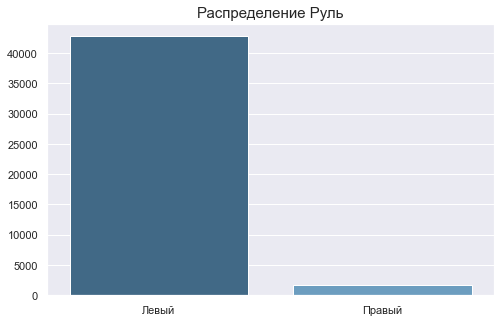

In [257]:
cat_plot('Руль', rotation=0)

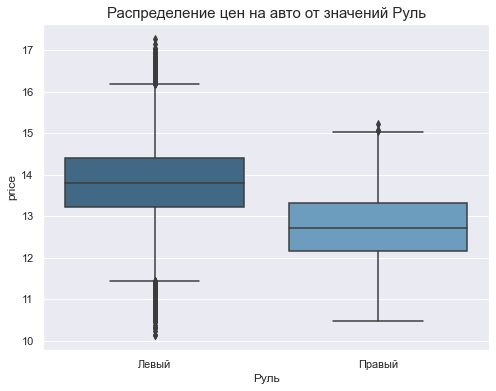

In [258]:
plt.figure(figsize=(8,6))
cat_boxplot('Руль', rotation=0)

- праворульных авто очень мало и стоят дешевле

In [259]:
check_values_train('Руль')
check_values_test('Руль')

Все уникальные значения test присутствуют в train
Все уникальные значения train присутствуют в test


In [260]:
steering_dict = {'Левый': 0, 'Правый': 1}

train.Руль = train.Руль.map(steering_dict)
test.Руль = test.Руль.map(steering_dict)

### Состояние

In [261]:
train.Состояние.value_counts()

Не требует ремонта    44526
Битый / не на ходу        1
Name: Состояние, dtype: int64

In [262]:
train.drop(train[train.Состояние == 'Битый / не на ходу'].index, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)

train.drop('Состояние', axis=1, inplace=True)
test.drop('Состояние', axis=1, inplace=True)


### Таможня

In [263]:
print('train')
display(train.Таможня.value_counts())
print()
print('test')
display(test.Таможня.value_counts())

train


Растаможен    44526
Name: Таможня, dtype: int64


test


Растаможен    34686
Name: Таможня, dtype: int64

In [264]:
train.dropna(subset=['Таможня'], inplace=True)

In [265]:
train.drop('Таможня', axis=1, inplace=True)
test.drop('Таможня', axis=1, inplace=True)

## Словари

### equipment_dict

Создадим бинарный датафрейм с комплектацией, проведем f_scores с таргетом и возьмем топ 50

In [266]:
train['equipment_dict'] = train['equipment_dict'].str.findall(r"'(\b.*?\b)'")
test['equipment_dict'] = test['equipment_dict'].str.findall(r'"(\b.*?\b)"')

In [267]:
mlb = MultiLabelBinarizer()

In [268]:
equipment_train = mlb.fit_transform(train['equipment_dict'])
equipment_test = mlb.transform(test['equipment_dict'])

equipment_train = pd.DataFrame(data = equipment_train, columns = mlb.classes_)
equipment_test = pd.DataFrame(data = equipment_test, columns = mlb.classes_)


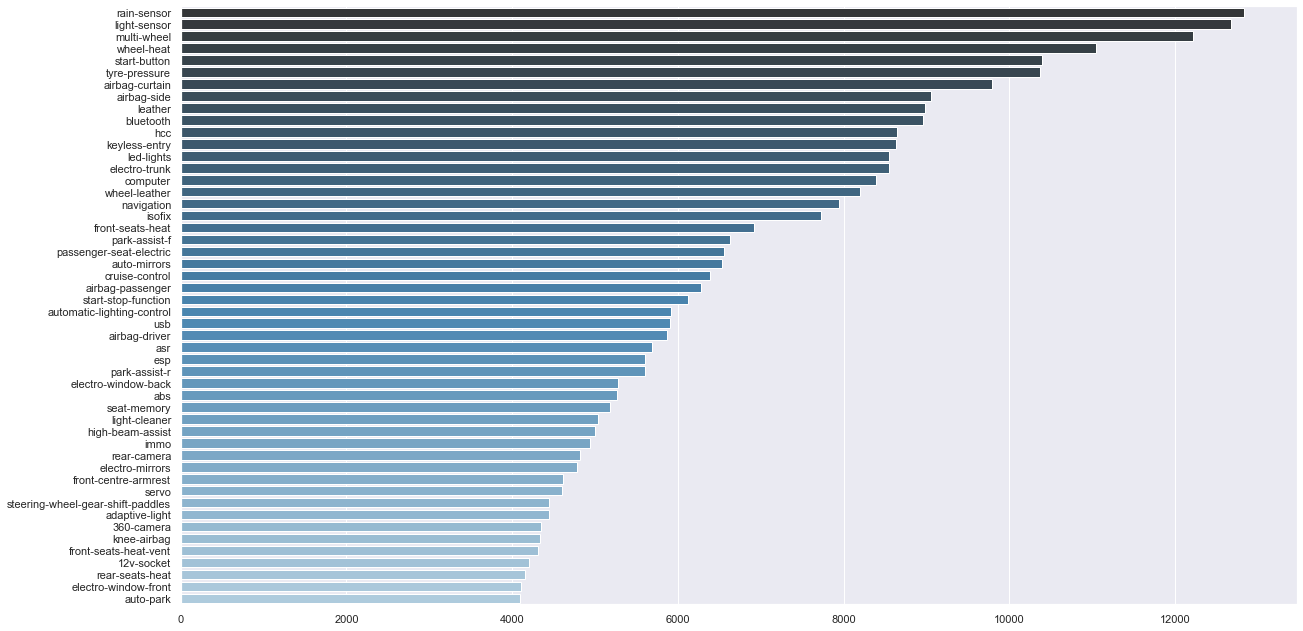

In [269]:
f_scores = f_regression(equipment_train, train.price)[0]
f_scores = pd.Series(f_scores, equipment_train.columns).sort_values(ascending=False)[:50]

plt.figure(figsize=(20,11))
sns.barplot(x=f_scores.values, y=f_scores.index, palette='Blues_r_d');

In [270]:
f_scores_top = f_scores.index

equipment_train = equipment_train[f_scores_top]
equipment_test = equipment_test[f_scores_top]

train = pd.concat([train, equipment_train], axis=1)
test = pd.concat([test, equipment_test], axis=1)

Создадим признаки длина словаря, присутствие редкого значения и топ значения

In [271]:
train['equipment_count'] = train['equipment_dict'].apply(len)
test['equipment_count'] = test['equipment_dict'].apply(len)
num_cols.append('equipment_count')

In [272]:
train['equipment_isna'] = train['equipment_count'].astype('bool') * 1
test['equipment_isna'] = test['equipment_count'].astype('bool') * 1

In [273]:
equipment_vc = train['equipment_dict'].explode().value_counts()
equipment_top_lst = equipment_vc.index[:10]
equipment_rare_lst = equipment_vc[equipment_vc < 50].index

In [274]:
def equipment_top(cell):
    x = 0
    for i in equipment_top_lst:
        if i in cell:
            x += 1
    return x

In [275]:
def equipment_rare(cell):
    x = 0
    for i in equipment_rare_lst:
        if i in cell:
            x += 1
    return x

In [276]:
train['equipment_top'] = train['equipment_dict'].apply(equipment_top)
test['equipment_top'] = test['equipment_dict'].apply(equipment_top)

train['equipment_rare'] = train['equipment_dict'].apply(equipment_rare)
test['equipment_rare'] = test['equipment_dict'].apply(equipment_rare)

In [277]:
train.drop('equipment_dict', axis=1, inplace=True)
test.drop('equipment_dict', axis=1, inplace=True)

### super_gen 

In [278]:
train.drop('super_gen', axis=1, inplace=True)
test.drop('super_gen', axis=1, inplace=True)

## Корреляция

In [279]:
corr = train[num_cols + ['price']].corr()

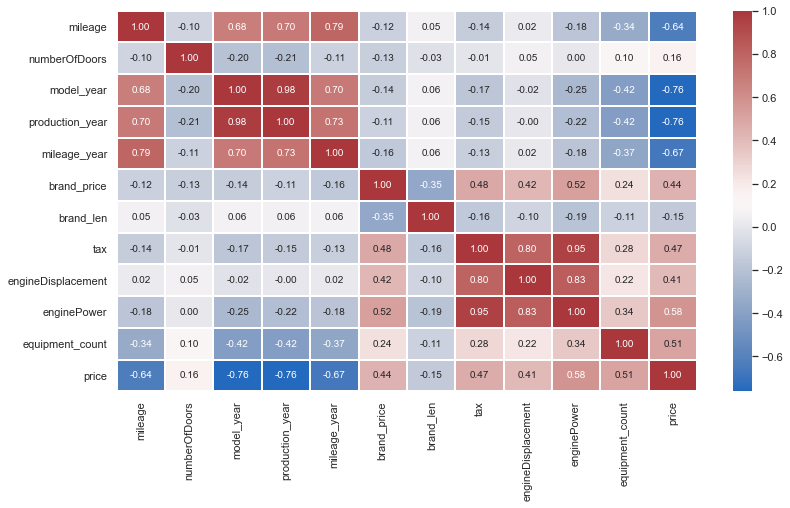

In [280]:
plt.figure(figsize=(13,7))
sns.heatmap(corr, annot=True, cmap='vlag',
            fmt='.2f', linewidths=0.1, annot_kws={"fontsize":10});

- Сильно коррелированные признаки не мешали древесным моделям.

## Encoder

### LabelEncoder

In [281]:
cols = ['color', 'bodyType', 'brand']

In [282]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for col in cols:
    train[col] = le.fit_transform(train[[col]])
    test[col] = le.transform(test[[col]])

### OneHotEncoder

In [283]:
df = pd.concat([train, test], axis=0)
df = pd.get_dummies(df)

train = df[~df.price.isna()]
test = df[df.price.isna()]

## Проверка значимости признаков

### Числовые

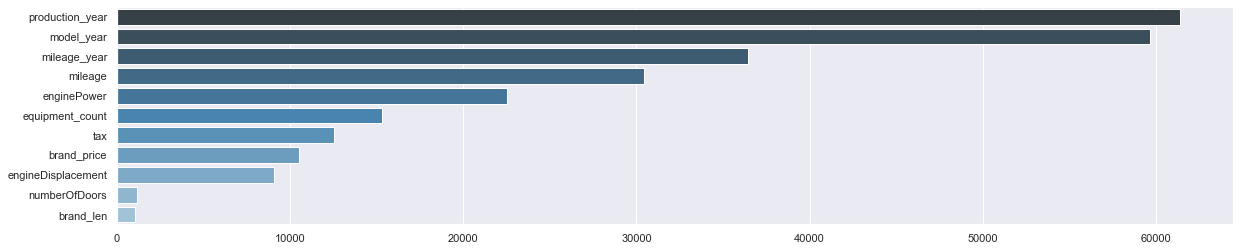

In [284]:
f_scores = f_regression(train[num_cols], train.price)[0]
f_scores = pd.Series(f_scores, num_cols).sort_values(ascending=False)

plt.figure(figsize=(20,4))
sns.barplot(x=f_scores.values, y=f_scores.index, palette='Blues_r_d');

### Категориальные + Бинарные

In [285]:
bin_cat_cols = set(train.columns) - set(num_cols) - set(['price'])

In [286]:
imp = mutual_info_regression(train[bin_cat_cols], train.price)
imp = pd.Series(imp, bin_cat_cols).sort_values(ascending=False)[:50]

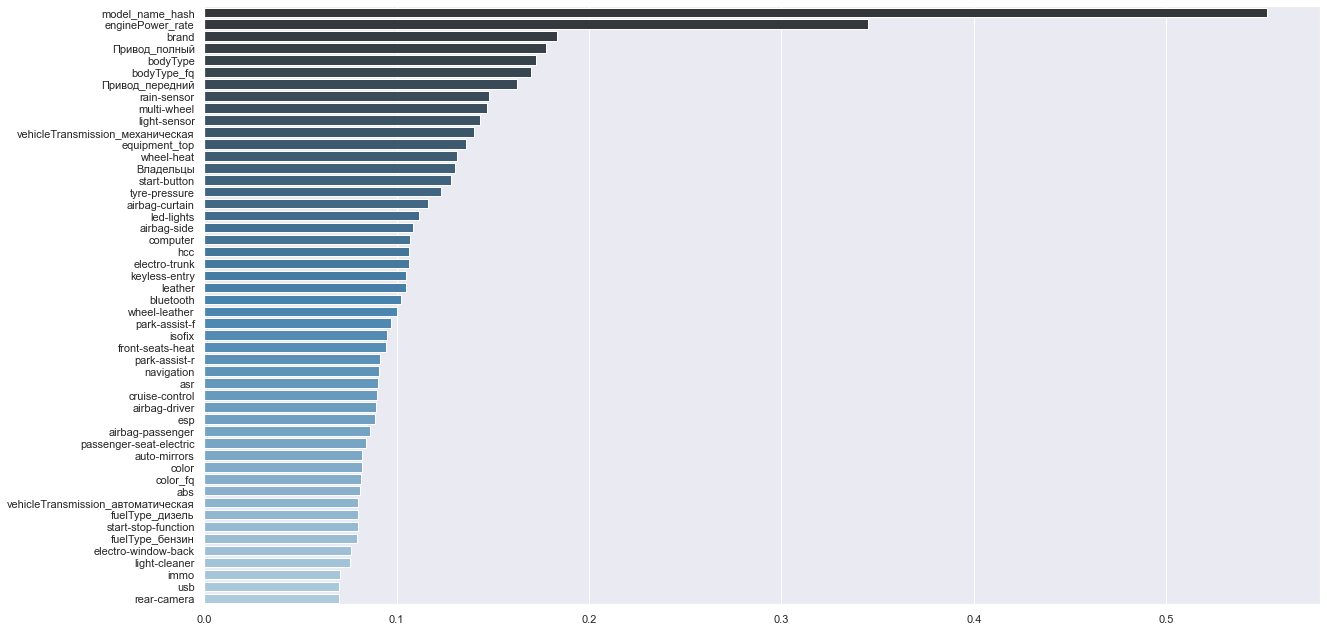

In [287]:
plt.figure(figsize=(20,11))
sns.barplot(x=imp.values, y=imp.index, palette='Blues_r_d');

## Модель

Отделим таргет и разобьем выборку на тренировочную и тестовую. Подберем параметры для моделей с помощью RandomizedSearchCV и закончим все стэкингом.

Наши данные более новые и цены выше чем на тесте. При сабмите учтем коэфицент 0.9

In [288]:
X = train.drop('price', axis=1)
y = train.price

In [289]:
test.drop('price', axis=1, inplace=True)

In [290]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test = np.exp(y_test)

### RandomForestRegressor

In [291]:
# param = {'n_estimators': [400],
#          'max_features': ['auto'],
#          'max_depth': [None, 10, 20, 30, 40],
#          'min_samples_split': [1, 2, 5, 10, 20],
#          'min_samples_leaf': [1, 2, 4, 8, 12]}

In [292]:
# rf = RandomForestRegressor(random_state=42)
# rcv = RandomizedSearchCV(estimator=rf, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=20)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE 

In [293]:
# rcv.best_params_

In [164]:
rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1,
                           min_samples_split=5, min_samples_leaf=1,
                           max_features='auto', max_depth=20)
rf.fit(X_train, y_train)
predict = rf.predict(X_test)
predict = np.exp(predict)
MAPE = mean_absolute_percentage_error(y_test, predict) * 100
MAPE

12.725269831383088

- submission MAPE = 13.85604

### ExtraTreesRegressor

In [133]:
# param = {'n_estimators': [200],
#          'max_features': ['auto'],
#          'max_depth': [None, 10, 20, 30, 40],
#          'min_samples_split': [1, 2, 5, 10, 20],
#          'min_samples_leaf': [1, 2, 4, 8, 12],
#          'bootstrap': [True, False]}

In [134]:
# etr = ExtraTreesRegressor(random_state=42)
# rcv = RandomizedSearchCV(estimator=etr, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=20)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

In [405]:
# rcv.best_params_

In [243]:
etr = ExtraTreesRegressor(n_estimators=800, random_state=42, n_jobs=-1,
                          bootstrap=False, min_samples_split=10, min_samples_leaf=1,
                          max_features='auto', max_depth=20)
etr.fit(X_train, y_train)
predict = etr.predict(X_test)
predict = np.exp(predict)
MAPE = mean_absolute_percentage_error(y_test, predict) * 100
MAPE

12.4784807371358

- submission MAPE = 13.61172

### CatBoostRegressor

In [407]:
# params = {'iterations': [5000],
#           'depth': [None, 4, 5, 6, 7],
#           'l2_leaf_reg': [0.1, 0.4, 1, 3, 5],
#           'random_strength': [0, 0.3, 0.7, 1]}

In [408]:
# cbr = CatBoostRegressor(random_seed=20, loss_function='MAPE', 
#                         eval_metric='MAPE', verbose=0)
# rs_cbr = cbr.randomized_search(params, X, y, cv=3, n_iter=20)
# rs_cbr['params']

In [240]:
cbr = CatBoostRegressor(iterations = 5000,
                        random_seed = 30,
                        loss_function='MAPE',
                        learning_rate=0.06,
                        depth=7,
                        random_strength=0.3,
                        l2_leaf_reg=0.15)

cbr.fit(X_train, y_train,
        eval_set=(X_test, np.log(y_test)),
        verbose_eval=0,
        use_best_model=True);

In [241]:
predict = np.exp(cbr.predict(X_test))
MAPE = mean_absolute_percentage_error(y_test, predict) * 100
MAPE

12.048123028644994

- submission MAPE = 12.83186

### XGBRegressor

In [1149]:
# param = {'n_estimators': [1000],
#          'colsample_bytree': [0.5, 0.75, 1.0],
#          'min_child_weight': [1, 3, 5],
#          'eta': [0.2],
#          'max_depth': [3, 6, 8],
#          'subsample': [0.5, 1.0]}

In [1150]:
# xgb = XGBRegressor(n_estimators=500, eval_metric='mape',random_state=42)
# rcv = RandomizedSearchCV(estimator=xgb, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=15)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

In [1151]:
# rcv.best_params_

In [264]:
xgb = XGBRegressor(objective='reg:squarederror', 
                      random_state=42,
                      n_estimators=2500,
                      eta=0.04,
                      max_depth=7,
                      eval_metric='mape')

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.04,
             eval_metric='mape', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0399999991,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2500, n_jobs=4,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [265]:
predict = xgb.predict(X_test)
predict = np.exp(predict)
MAPE = mean_absolute_percentage_error(y_test, predict) * 100
MAPE

12.268338520204853

- submission MAPE = 13.25148

### LGBMRegressor

In [266]:
# param = {'n_estimators': [2500],
#          'learning_rate': [0.1],
#          'max_depth': [-1, 2, 4, 6],
#          'num_leaves': [20, 30 , 40, 50],
#          'min_child_samples': [None, 5, 10, 20],
#          'lambda_l2': [0.05, 0.1, 0.3, 0.8, 1.5]}

In [267]:
# lgbm = LGBMRegressor(objective='regression', random_state=30)
# rcv = RandomizedSearchCV(estimator=lgbm, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=15)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

In [268]:
# rcv.best_params_

In [239]:
lgbm = LGBMRegressor(objective='mape', 
                     random_state=30,
                     n_estimators=2500,
                     learning_rate=0.05,
                     lambda_l2=0.5)

lgbm.fit(X_train, y_train,
         eval_set=(X_test, np.log(y_test)))

[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[1]	valid_0's mape: 0.0533432
[2]	valid_0's mape: 0.0511863
[3]	valid_0's mape: 0.0491522
[4]	valid_0's mape: 0.047257
[5]	valid_0's mape: 0.0453901
[6]	valid_0's mape: 0.0435844
[7]	valid_0's mape: 0.0418855
[8]	valid_0's mape: 0.0402558
[9]	valid_0's mape: 0.0387504
[10]	valid_0's mape: 0.0373456
[11]	valid_0's mape: 0.0359821
[12]	valid_0's mape: 0.0347543
[13]	valid_0's mape: 0.0335386
[14]	valid_0's mape: 0.0323667
[15]	valid_0's mape: 0.0312343
[16]	valid_0's mape: 0.0301719
[17]	valid_0's mape: 0.0292114
[18]	valid_0's mape: 0.0282911
[19]	valid_0's mape: 0.0274021
[20]	valid_0's mape: 0.0265635
[21]	valid_0's mape: 0.0258
[22]	valid_0's mape: 0.025059
[23]	valid_0's mape: 0.0243622
[24]	valid_0's mape: 0.0237071
[25]	valid_0's mape: 0.0230771
[26]	valid_0's mape: 0.0224821
[27]	valid_0's mape: 0.0218971
[28]	valid_0's mape: 0.0213539
[29]	valid_0's mape: 0.0208594
[30]	valid_

LGBMRegressor(lambda_l2=0.5, learning_rate=0.05, n_estimators=2500,
              objective='mape', random_state=30)

In [238]:
predict = lgbm.predict(X_test)
predict = np.exp(predict)
MAPE = mean_absolute_percentage_error(y_test, predict) * 100
MAPE

12.154962225843075

- submission MAPE = 13.36784

### StackingRegressor

In [272]:
estimators = [('cbr', cbr), ('xgb', xgb), ('etr', etr), ('lgbm', lgbm)]
stacking = StackingRegressor(estimators=estimators,
                             final_estimator=Ridge())
stacking.fit(X_train, y_train)

0:	learn: 0.0530766	total: 31.2ms	remaining: 2m 35s
1:	learn: 0.0506928	total: 73.4ms	remaining: 3m 3s
2:	learn: 0.0484105	total: 105ms	remaining: 2m 54s
3:	learn: 0.0462871	total: 143ms	remaining: 2m 58s
4:	learn: 0.0442861	total: 181ms	remaining: 3m
5:	learn: 0.0423428	total: 242ms	remaining: 3m 21s
6:	learn: 0.0405372	total: 279ms	remaining: 3m 18s
7:	learn: 0.0388717	total: 310ms	remaining: 3m 13s
8:	learn: 0.0372941	total: 350ms	remaining: 3m 14s
9:	learn: 0.0357524	total: 381ms	remaining: 3m 10s
10:	learn: 0.0343514	total: 412ms	remaining: 3m 6s
11:	learn: 0.0329706	total: 448ms	remaining: 3m 6s
12:	learn: 0.0316335	total: 479ms	remaining: 3m 3s
13:	learn: 0.0304700	total: 524ms	remaining: 3m 6s
14:	learn: 0.0293073	total: 562ms	remaining: 3m 6s
15:	learn: 0.0282089	total: 593ms	remaining: 3m 4s
16:	learn: 0.0271850	total: 623ms	remaining: 3m 2s
17:	learn: 0.0263129	total: 669ms	remaining: 3m 5s
18:	learn: 0.0254050	total: 702ms	remaining: 3m 4s
19:	learn: 0.0245922	total: 734ms	

StackingRegressor(estimators=[('cbr',
                               <catboost.core.CatBoostRegressor object at 0x0000026FB6A54FD0>),
                              ('xgb',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, eta=0.04,
                                            eval_metric='mape', gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.0399999991,
                                            max_delta_step=0, ma...
                                            random_state=42, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                               

In [273]:
predict = stacking.predict(X_test)
predict = np.exp(predict)
MAPE = mean_absolute_percentage_error(y_test, predict) * 100
MAPE

11.731474645129367

- submission MAPE = 12.77339

## Резюмируем

 - **StackingRegressor (из моделей ниже, кроме RandomForestRegressor, финальная модель Ridge) - 11.73**
 - CatBoostRegressor- 12.05
 - LGBMRegressor - 12.16
 - XGBRegressor - 12.27
 - ExtraTreesRegressor - 12.48
 - RandomForestRegressor - 12.73

## Submission

In [448]:
predict = np.exp(stacking.predict(test))

submission = pd.read_csv('sample_submission.csv')
submission['price'] = predict * 0.9
submission.to_csv('submission-1.csv', index=False)

In [451]:
submission.head(6)

,sell_id,price
0,1100575026,6.161474e+05
1,1100549428,1.028566e+06
2,1100658222,9.416918e+05
3,1100937408,8.305327e+05
4,1101037972,7.258120e+05
5,1100912634,6.942975e+05
